In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
import torch
import torch.nn.functional as F
import pandas as pd
import torchvision
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torchmetrics.classification import MulticlassConfusionMatrix, F1Score, MulticlassPrecision, MulticlassRecall, MulticlassPrecisionRecallCurve, MulticlassROC
from torch.optim import lr_scheduler
import torch.nn as nn
import torch
import pytorch_lightning as pl
from torch.utils.tensorboard import SummaryWriter
from matplotlib.backends.backend_agg import FigureCanvasAgg

import confinement_mode_classifier as cmc
import alt_models as am


In [2]:
signal_window = 320
num_workers = 32
signal_name = 'mc'
batch_size = 512
pl.seed_everything(42)
path=os.getcwd()

shot_usage = pd.read_csv(f'{path}/data/shot_usage.csv')
shot_for_ris = shot_usage[shot_usage['used_for_alt']]
shot_numbers = shot_for_ris['shot']
shots_for_testing = shot_for_ris[shot_for_ris['used_as'] == 'test']['shot']
shots_for_validation = shot_for_ris[shot_for_ris['used_as'] == 'val']['shot']

shot_df, test_df, val_df, train_df = am.split_df(path, shot_numbers, shots_for_testing, shots_for_validation, use_ELMS=True)


# Create dataloaders
train_dataloader = am.get_dloader(train_df, batch_size=batch_size, 
                            balance_data=True, shuffle=False, 
                            signal_window=signal_window,
                            signal_name=signal_name,
                            num_workers=num_workers)

val_dataloader = am.get_dloader(val_df, batch_size=batch_size, 
                            balance_data=True, shuffle=False, 
                            signal_window=signal_window,
                            signal_name=signal_name,
                            num_workers=num_workers)

test_dataloader = am.get_dloader(test_df, batch_size=batch_size, 
                            balance_data=False, shuffle=False, 
                            signal_window=signal_window,
                            signal_name=signal_name,
                            num_workers=num_workers)

Seed set to 42


In [3]:
model = am.select_model_architecture('InceptionTime', num_classes=3, window=320)
model.load_state_dict(torch.load(f'/compass/Shared/Users/bogdanov/vyzkumny_ukol/runs/24-02-22, 18-31-57 InceptionTime_on_Mink_coil_320dpoints_16_epochs/model.pt'))
model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

Sequential(
  (0): Reshape()
  (1): InceptionBlock(
    (activation): ReLU()
    (inception_1): Inception(
      (conv_from_bottleneck_1): Conv1d(1, 32, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
      (conv_from_bottleneck_2): Conv1d(1, 32, kernel_size=(11,), stride=(1,), padding=(5,), bias=False)
      (conv_from_bottleneck_3): Conv1d(1, 32, kernel_size=(23,), stride=(1,), padding=(11,), bias=False)
      (max_pool): MaxPool1d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
      (conv_from_maxpool): Conv1d(1, 32, kernel_size=(1,), stride=(1,), bias=False)
      (batch_norm): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): ReLU()
    )
    (inception_2): Inception(
      (bottleneck): Conv1d(128, 32, kernel_size=(1,), stride=(1,), bias=False)
      (conv_from_bottleneck_1): Conv1d(32, 32, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
      (conv_from_bottleneck_2): Conv1d(32, 32, kernel_siz

Processing batches:   0%|          | 0/1079 [00:00<?, ?it/s]

Processing metrics...


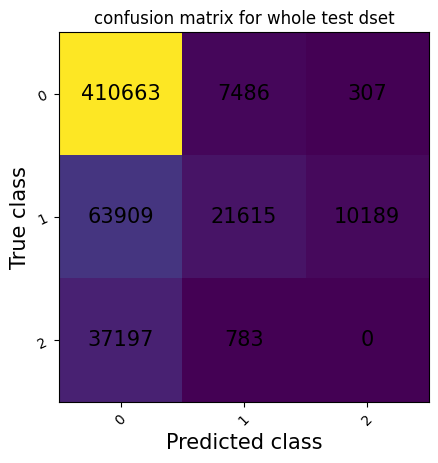

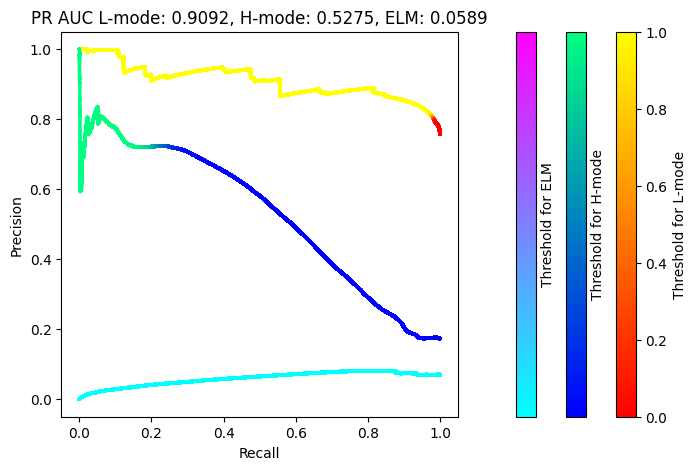

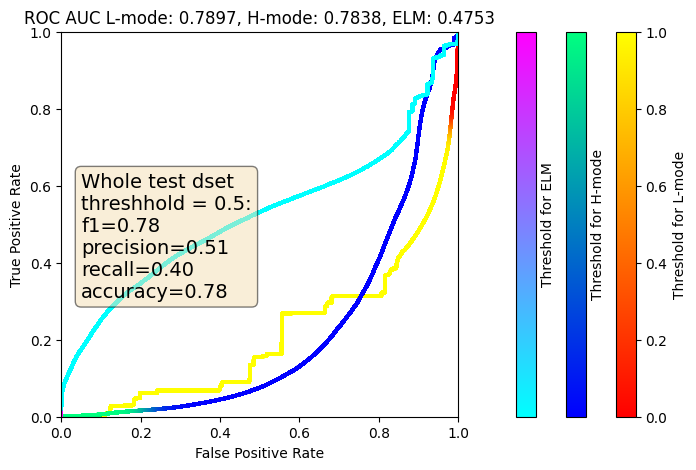

In [4]:
metrics = am.test_model('/compass/Shared/Users/bogdanov/vyzkumny_ukol/runs/24-02-22, 18-31-57 InceptionTime_on_Mink_coil_320dpoints_16_epochs', model, test_dataloader, signal_name=signal_name, max_batch=0)

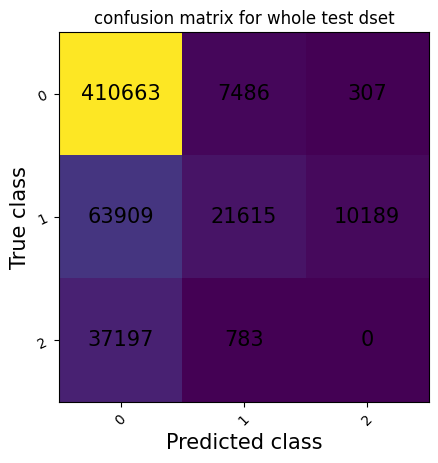

In [5]:
metrics['confusion_matrix'][0]

In [6]:
preds = metrics['prediction_df']

In [7]:
softmax_out = torch.nn.functional.softmax(torch.tensor(preds[['L_logit','H_logit','ELM_logit']].values), dim=1)

In [8]:
y_df = torch.tensor(preds['label'].values.astype(int))
y_df

tensor([0, 0, 0,  ..., 0, 0, 0])

In [9]:
preds['label'].values

array([0, 0, 0, ..., 0, 0, 0], dtype=object)

In [10]:
pr_roc_auc = cmc.pr_roc_auc(y_df, softmax_out, task='ternary')

KeyboardInterrupt: 

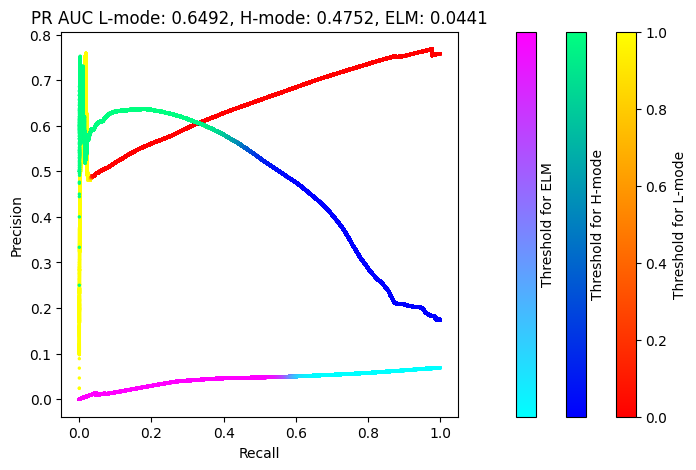

In [ ]:
pr_roc_auc['pr_curve'][0]

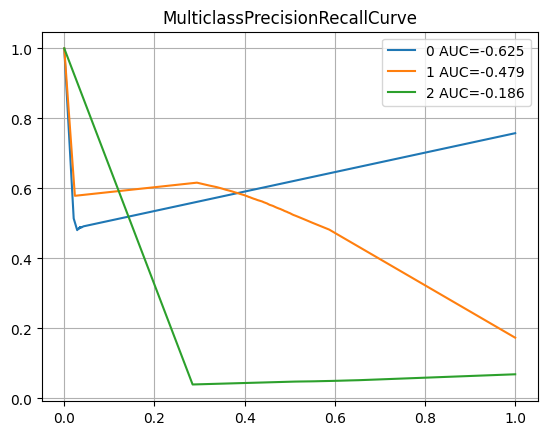

In [ ]:
pr_curve = MulticlassPrecisionRecallCurve(num_classes=3, thresholds=64)
pr_curve.update(softmax_out, y_df)
pr_curve_fig, pr_curve_ax = pr_curve.plot(score=True)
#ROC metric
mcroc = MulticlassROC(num_classes=3, thresholds=64)
mcroc.update(torch.tensor(preds[['L_logit', 'H_logit', 'ELM_logit']].values.astype(float)), y_df)
roc_fig, roc_ax = mcroc.plot(score=True)

pr_curve_fig

In [ ]:
from importlib import reload
reload(cmc)

<module 'confinement_mode_classifier' from '/compass/Shared/Users/bogdanov/vyzkumny_ukol/confinement_mode_classifier.py'>

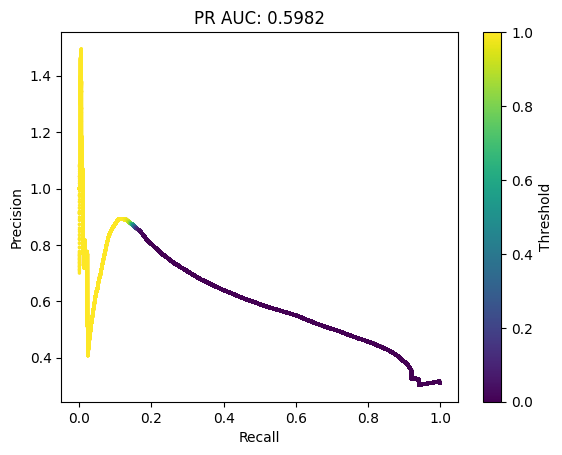

In [ ]:
pr_roc_auc[0]['pr_curve'][0]

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

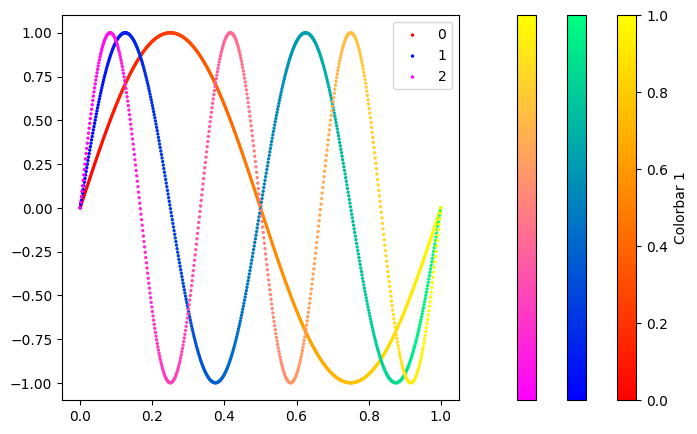

In [ ]:
fig_pr, ax_pr = plt.subplots(figsize=(10, 5))
x = np.linspace(0, 1, 600)
y = np.sin(x*2*np.pi)

# Define the color maps for the scatter plots
cmaps = ['autumn', 'winter', 'spring']


# Create colorbars
cbar = []
for i, cmap in enumerate(cmaps):
    scatter = ax_pr.scatter(x, np.sin((i+1)*x*2*np.pi), c=x, cmap=cmap, s=2, label=f'{i}')
    cbar.append(fig_pr.colorbar(scatter))
ax_pr.legend()
# Remove ticks from the second and third colorbars
for i in range(1, len(cbar)):
    cbar[i].set_ticks([])
cbar[0].set_label('Colorbar 1')

# Adjust the main plot to make space for colorbars
#plt.subplots_adjust(right=1)

# Manually set the position of the colorbars to reduce whitespace
for i, cb in enumerate(cbar):
    pos = cb.ax.get_position()
    cb.ax.set_position([0.68 - i*0.05, pos.y0, 0.02, pos.height])

